In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')
df.head(5)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [3]:
# the first number means start pixel, the second number means the range start from the first number.
def DecodedPixels(val):
    val_split = val.split(' ')
    decode_result = {}
    for i in range(0, len(val_split), 2):
        decode_result[int(val_split[i])] = int(val_split[i+1])

    return decode_result


# from top to bottom, then from left to right
def DecodePixel_To_ArrayIdx(val, image_height, image_width):
    row = val % image_height - 1  # remember the index starts from 0
    col = val // image_height

    return row, col

In [4]:
def mark_defect(img, defect_info, color=[255, 50, 50]):
    for k in defect_info.keys():
        for i in range(defect_info[k]):
            arr_row, arr_col = DecodePixel_To_ArrayIdx(k+i, height, width)
            img[arr_row, arr_col] = color

    return img
    

def merge_image(imgArray1, imgArray2, alpha_val=0.3):
    h1, w1, _ = imgArray1.shape
    h2, w2, _ = imgArray2.shape
    
    if h1 != h2 or w1 != w2:
        imgArray2 = cv2.resize(imgArray2, (w1, h1), interpolation=cv2.INTER_AREA)

    alpha = alpha_val # weight of the first array elements.
    beta = 1 - alpha # weight of the second array elements.
    gamma = 0 # scalar added to each sum
    
    mergeResult = cv2.addWeighted(imgArray1, alpha, imgArray2, beta, gamma)
    
    return mergeResult

## Single image test

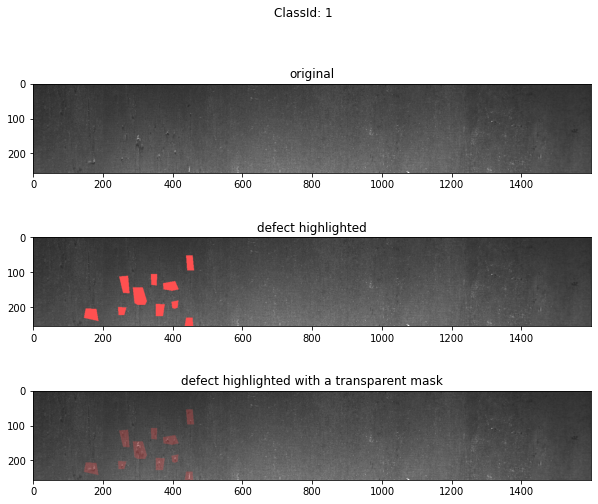

In [7]:
image_dir = 'train_images'
img_list = os.listdir(image_dir)

target_image = img_list[2]
full_path = os.path.join(image_dir, target_image)
img = cv2.imread(full_path)
img_copy = img.copy()
height, width, channel = img_copy.shape

classId = df[df['ImageId'].str.contains(target_image)]['ClassId'].values[0]

# mark the defect position with color
defect_info = DecodedPixels(df[df['ImageId'] == target_image]['EncodedPixels'].values[0])
img_copy = mark_defect(img_copy, defect_info, color=[255, 80, 80])

# merge two image
img_merge = merge_image(img, img_copy, 0.7)

# show the image
f = plt.figure(figsize=(10, 8))
f.suptitle(f'ClassId: {classId}')
f.add_subplot(3, 1, 1)
plt.title('original')
plt.imshow(img)

f.add_subplot(3, 1, 2)
plt.title('defect highlighted')
plt.imshow(img_copy)

f.add_subplot(3, 1, 3)
plt.title('defect highlighted with a transparent mask')
plt.imshow(img_merge)